In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="7"

Wed Jan 17 17:54:15 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   32C    P0    43W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.uniform_prior import Prior
from model.latent.swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 3
hp.out_dim = 3
hp.z_dim = 128
hp.h_dims = [32, 64, 128, 256, 512]
hp.activation = F.sigmoid

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.99169921875
encoder.convs 5.9912109375
encoder.linear 1.00048828125
prior 0.0
latent 0.0
decoder 7.028697967529297
decoder.linear 1.0078125
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_celeba/train01.17-7/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

test_transforms = transforms.Compose([transforms.CenterCrop(148),
                                      transforms.Resize(hp.size),
                                      transforms.ToTensor(),])
test_dataset = MyCelebA(root, split='test', transform=test_transforms, download=False)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=False)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

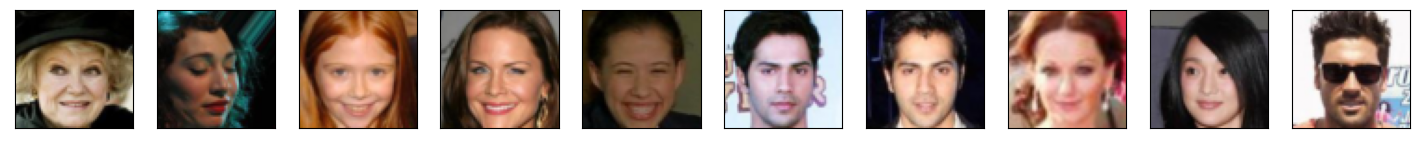

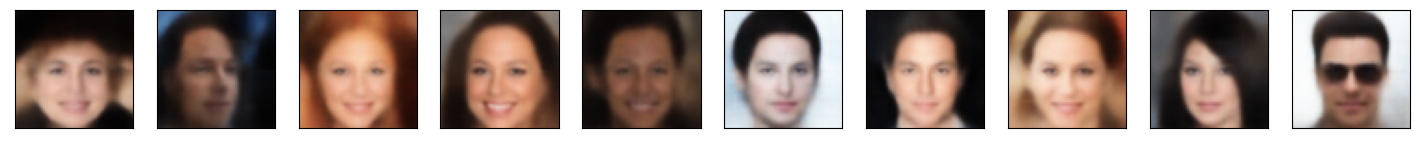

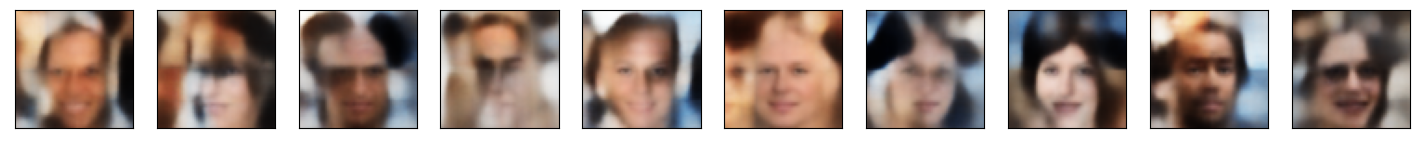

11001
swae_loss 0.011219718400388956
recon_loss 0.008814591355621815
11002
swae_loss 0.01080202478915453
recon_loss 0.00881553627550602
11003
swae_loss 0.010689179226756097
recon_loss 0.008733371738344431
11004
swae_loss 0.011286336183547973
recon_loss 0.00859874179586768
11005
swae_loss 0.010835752449929714
recon_loss 0.008667417615652085
11006
swae_loss 0.010056393500417472
recon_loss 0.009315211977809667
11007
swae_loss 0.011227791290730238
recon_loss 0.008422701712697744
11008
swae_loss 0.011013210192322731
recon_loss 0.00872949454933405
11009
swae_loss 0.010466145351529121
recon_loss 0.008814610447734595
11010
swae_loss 0.010338461119681596
recon_loss 0.008746053930372
11011
swae_loss 0.010749450605362653
recon_loss 0.008917412161827088
11012
swae_loss 0.010943073127418757
recon_loss 0.008594166208058595
11013
swae_loss 0.010847607813775539
recon_loss 0.008355757966637612
11014
swae_loss 0.01096886359155178
recon_loss 0.008553981035947799
11015
swae_loss 0.01041170721873641
recon_

11121
swae_loss 0.01138797178864479
recon_loss 0.008620272390544415
11122
swae_loss 0.010475101135671138
recon_loss 0.008991293236613273
11123
swae_loss 0.01191273657605052
recon_loss 0.009164415672421456
11124
swae_loss 0.011322760954499245
recon_loss 0.008589956909418106
11125
swae_loss 0.011772335600107908
recon_loss 0.008451525494456292
11126
swae_loss 0.011457850690931082
recon_loss 0.008564399369060994
11127
swae_loss 0.011114229913800955
recon_loss 0.008296137396246194
11128
swae_loss 0.011714862938970328
recon_loss 0.008437252882868052
11129
swae_loss 0.011147644463926553
recon_loss 0.008833003882318734
11130
swae_loss 0.010428761411458255
recon_loss 0.008987846225500107
11131
swae_loss 0.01101248264312744
recon_loss 0.00860717035830021
11132
swae_loss 0.01096774274483323
recon_loss 0.008772572502493858
11133
swae_loss 0.011735098995268345
recon_loss 0.009097448643296957
11134
swae_loss 0.010865792166441679
recon_loss 0.008953239768743515
11135
swae_loss 0.0107249123044312
reco

11241
swae_loss 0.010501895565539598
recon_loss 0.008302649576216936
11242
swae_loss 0.010740073956549167
recon_loss 0.008902853541076183
11243
swae_loss 0.010678372718393803
recon_loss 0.008398572728037835
11244
swae_loss 0.010788238514214754
recon_loss 0.008792343735694885
11245
swae_loss 0.01039739241823554
recon_loss 0.008361589536070824
11246
swae_loss 0.010894355829805136
recon_loss 0.008437066618353129
11247
swae_loss 0.011564638931304216
recon_loss 0.008212931361049414
11248
swae_loss 0.011746114678680896
recon_loss 0.008681360445916653
11249
swae_loss 0.01188855990767479
recon_loss 0.00860234722495079
11250
swae_loss 0.01137974951416254
recon_loss 0.00873329434543848
11251
swae_loss 0.011573929898440838
recon_loss 0.008418716862797737
11252
swae_loss 0.010968075599521399
recon_loss 0.00811940971761942
11253
swae_loss 0.01081140162423253
recon_loss 0.008619162160903216
11254
swae_loss 0.011304828338325024
recon_loss 0.008689702115952968
11255
swae_loss 0.011012238170951604
reco

11361
swae_loss 0.010650086868554353
recon_loss 0.008708721864968539
11362
swae_loss 0.010772604774683715
recon_loss 0.00891394605860114
11363
swae_loss 0.011845901422202588
recon_loss 0.008329705148935319
11364
swae_loss 0.010746808908879756
recon_loss 0.008606065902858973
11365
swae_loss 0.011234106589108705
recon_loss 0.00875175166875124
11366
swae_loss 0.010847317241132259
recon_loss 0.008421144634485244


In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = model.prior.sample(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        